## Data Prepare & Labeled

In [53]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd

In [2]:
# df = pd.read_excel('dataset/redbook.xlsx')
# label_df = df.sample(1000)
# label_df.to_csv('dataset/sample_1000.csv')

In [56]:
sample_df = pd.read_excel('dataset/sample_1000.xlsx')
sample_df['category'] = sample_df['情感倾向'].apply(lambda x: 'O' if x == '其他' else x)

### EDA

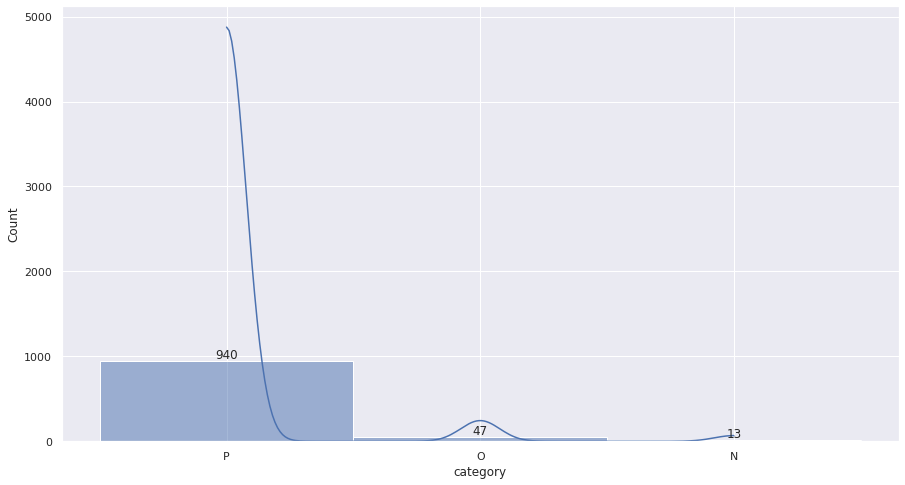

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

y = sns.histplot(sample_df['category'], kde=True, stat="count")
y.bar_label(y.containers[0])
plt.show()

### Text vectorization

In [40]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')

### Model

In [41]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### DataLoader

In [42]:
import torch
import numpy as np

labels = {'N': 0,
          'P': 1,
          'O': 2
          }


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [
            tokenizer(
                str(row["title"]) + " " + str(row["content"]),
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        try:
            return np.array(self.labels[idx])
        except:
            print(idx)
            print(self.labels)

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


### Training

In [43]:
import torch
import os
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs, log_dir='./model', continue_train_path='./model/bert_training_model.pth'):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    criterion = nn.CrossEntropyLoss()

    start_epoch = 0
    optimizer = Adam(model.parameters(), lr=learning_rate)
    if os.path.exists(continue_train_path):
        checkpoint = torch.load(continue_train_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    best_model = None
    best_optimizer = None
    best_epoch = None
    best_val_loss = 0


    for epoch in range(start_epoch+1, epochs):

        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        var_acc = total_acc_val / len(val_data)
        var_loss = total_loss_val / len(val_data)
        print(
            f"Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {var_loss: .3f} \
                | Val Accuracy: {var_acc: .3f}"
        )

        if best_val_loss < var_loss:
            best_val_loss = var_loss
            best_model = model
            best_optimizer = optimizer
            best_epoch = epoch
            # save model
            torch.save({
                'model': best_model.state_dict(),
                'optimizer': best_optimizer.state_dict(),
                'epoch': best_epoch
            }, f'{log_dir}/bert_best_model.pth')
        
        # save model
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch
        }, f'{log_dir}/bert_training_model.pth')


### Evaluate

In [44]:
import torch

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    test_pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            test_pred = test_pred + output.argmax(dim=1).tolist()
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return test_pred, test.labels


### Split data

In [45]:
import numpy as np

df_train, df_val, df_test = np.split(
    sample_df.sample(frac=1, random_state=42),
    [int(0.8 * len(sample_df)), int(0.9 * len(sample_df))],
)

In [9]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

np.random.seed(112)

########## TODO: random labeled############
# sample_df['category'] = np.random.randint(0,4, size=len(sample_df))

print(len(df_train), len(df_val), len(df_test))

train(model, df_train.reset_index(drop=True), df_val.reset_index(drop=True), LR, EPOCHS)


Some weights of the model checkpoint at uer/roberta-base-finetuned-chinanews-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


800 100 100


100%|██████████| 400/400 [00:48<00:00,  8.19it/s]


Epochs: 2 | Train Loss:  0.521                 | Train Accuracy:  0.686                 | Val Loss:  0.247                 | Val Accuracy:  0.930


100%|██████████| 400/400 [00:49<00:00,  8.11it/s]


Epochs: 3 | Train Loss:  0.176                 | Train Accuracy:  0.936                 | Val Loss:  0.143                 | Val Accuracy:  0.950


100%|██████████| 400/400 [00:49<00:00,  8.07it/s]


Epochs: 4 | Train Loss:  0.129                 | Train Accuracy:  0.941                 | Val Loss:  0.119                 | Val Accuracy:  0.950


100%|██████████| 400/400 [00:49<00:00,  8.07it/s]


Epochs: 5 | Train Loss:  0.115                 | Train Accuracy:  0.941                 | Val Loss:  0.112                 | Val Accuracy:  0.950


In [47]:
# load best bert model
model = BertClassifier()
checkpoint = torch.load('./model/bert_best_model.pth')
model.load_state_dict(checkpoint['model'])
#evaluate
test_pred, test_target = evaluate(model, df_test.reset_index(drop=True))

Some weights of the model checkpoint at uer/roberta-base-finetuned-chinanews-chinese were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.920


### Classification report

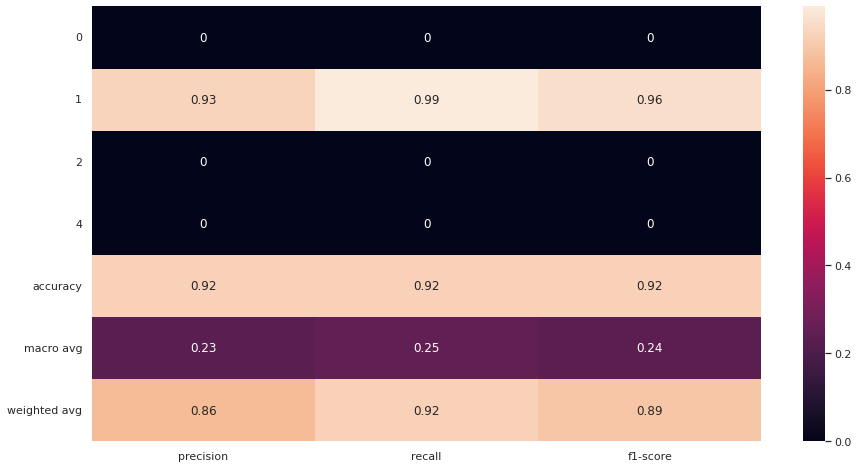

In [54]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

gin_clf_report = classification_report(test_target, test_pred, output_dict=True)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(pd.DataFrame(gin_clf_report).iloc[:-1, :].T, annot=True)
plt.show()

### EDA

In [30]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black'
    ).generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k'
    )
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()